In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm
from scipy.stats import entropy
from sklearn.linear_model import LogisticRegression
from polyagamma import random_polyagamma
from utils.generate import GenerateData_binomial
from utils.metrics import KLD
from models.proposed_method import proposed_method_binomial
from models.compared_methods import compared_methods

In [5]:
import warnings
warnings.filterwarnings('ignore')

# バイアスアルゴリズム：ステップ

In [29]:
Ex_num = 100 # パラメータを生成する回数

# 特徴量の数を設定
n_features = 1

# 特徴量の平均と標準偏差を設定
X_mu = [1]
X_sigma = [3]

# パラメータの平均と標準偏差を設定
beta_mu = [-2,4]
beta_sigma = [0.5,0.5]

threshfold_list = [-3, -1, 1, 3]

KL_list = [] # 結果格納用 (threshfoldの数, 3)→ 標本平均, 比較手法，提案手法

for threshfold in threshfold_list:

    KL_list_proposed_by_condition = []
    KL_list_sample_mean_by_condition = []
    KL_list_ML_by_condition = []

    trial = 0
    with tqdm() as pbar:
        while trial < Ex_num: # パラメータによるモンテカルロ平均（ベイズ最適な推定量）
            # クラスをインスタンス化
            generator = GenerateData_binomial(
                n_features=n_features,
                X_mu_list=X_mu,
                X_sigma_list=X_sigma,
                beta_mu=beta_mu, # beta_mu_matrixをbeta_muに変更
                beta_sigma=beta_sigma # beta_sigma_matrixをbeta_sigmaに変更
            )

            # データを生成
            X, y = generator.generate_non_bias_data()
            X_bias, y_bias = generator.generate_bias_data(n_samples=100, X_features_bias= 1 , threshfold= threshfold,sample_type="threshfold_step")

            if (y_bias.mean() != 1) & (y_bias.mean() != 0): # 0と1両方あるサンプルが生成できた場合のみ計算を実行する

                b_0 = np.array([0.001, 0.001])
                B_0 = np.array([np.diag([100, 100])]) # B_0の形状を変更

                burn = 2000
                draw = 5000

                # proposed_method_binomialのインスタンスを作成
                method = proposed_method_binomial(X_bias, y_bias, b_0, B_0, X_mu, X_sigma, burn, draw) # proposed_methodをproposed_method_binomialに変更
                compared_method = compared_methods(X_bias, y_bias, X_mu, X_sigma)

                # sample_betaメソッドを実行
                beta_posterior = method.sample_beta()

                P_true = y.mean()
                P_sample_mean = y_bias.mean()
                P_ML = compared_method.maximum_likelihood(draw=draw)
                P_proposed = method.estimate()

                KL_list_sample_mean_by_condition.append(KLD(P_true, P_sample_mean))
                KL_list_ML_by_condition.append(KLD(P_true, P_ML))
                KL_list_proposed_by_condition.append(KLD(P_true, P_proposed))

                pbar.update(1)
                trial += 1
            else:
                print("バイアスサンプルの生成に失敗しました")

    # 提案手法と比較手法の結果を表示
    print(f"実験条件:{threshfold=}")
    print("サンプル平均P:", np.mean(KL_list_sample_mean_by_condition))
    print("最尤推定P:", np.mean(KL_list_ML_by_condition))
    print("提案手法P:", np.mean(KL_list_proposed_by_condition))

    KL_list.append([np.mean(KL_list_sample_mean_by_condition), np.mean(KL_list_ML_by_condition), np.mean(KL_list_proposed_by_condition)])
KL_list

100it [02:25,  1.45s/it]


実験条件:threshfold=-3
サンプル平均P: 0.03632245266808537
最尤推定P: 0.002491467982047276
提案手法P: 0.0012316208983992594


100it [02:25,  1.45s/it]


実験条件:threshfold=-1
サンプル平均P: 0.0048393466922097275
最尤推定P: 0.0029114013781592783
提案手法P: 0.0008932521037037833


100it [02:24,  1.45s/it]


実験条件:threshfold=1
サンプル平均P: 0.07583689008656828
最尤推定P: 0.0028416236108722826
提案手法P: 0.0014449908056662353


100it [02:15,  1.36s/it]

実験条件:threshfold=3
サンプル平均P: 0.16212645969931563
最尤推定P: 0.003308321419919019
提案手法P: 0.001960906169457015


[[np.float64(0.03632245266808537),
  np.float64(0.002491467982047276),
  np.float64(0.0012316208983992594)],
 [np.float64(0.0048393466922097275),
  np.float64(0.0029114013781592783),
  np.float64(0.0008932521037037833)],
 [np.float64(0.07583689008656828),
  np.float64(0.0028416236108722826),
  np.float64(0.0014449908056662353)],
 [np.float64(0.16212645969931563),
  np.float64(0.003308321419919019),
  np.float64(0.001960906169457015)]]

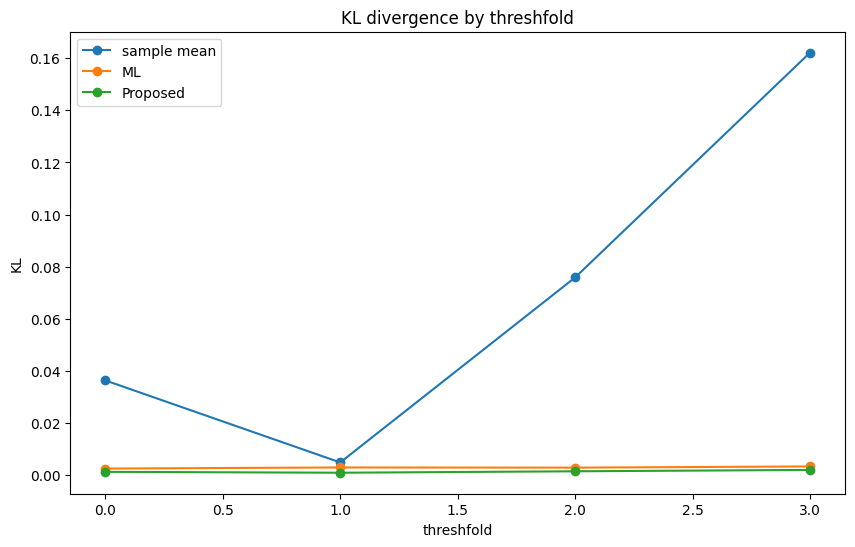

In [32]:
KL_list = np.array(KL_list).T
label = ["sample mean", "ML", "Proposed"]

plt.figure(figsize=(10, 6))
for i in range(3):
    plt.plot(KL_list[i], marker='o', linestyle='-', label=label[i]) # マーカーを'o'に設定し、線種を'-'に設定
plt.xlabel("threshfold")
plt.ylabel("KL")
plt.legend()
plt.title("KL divergence by threshfold")
plt.show()



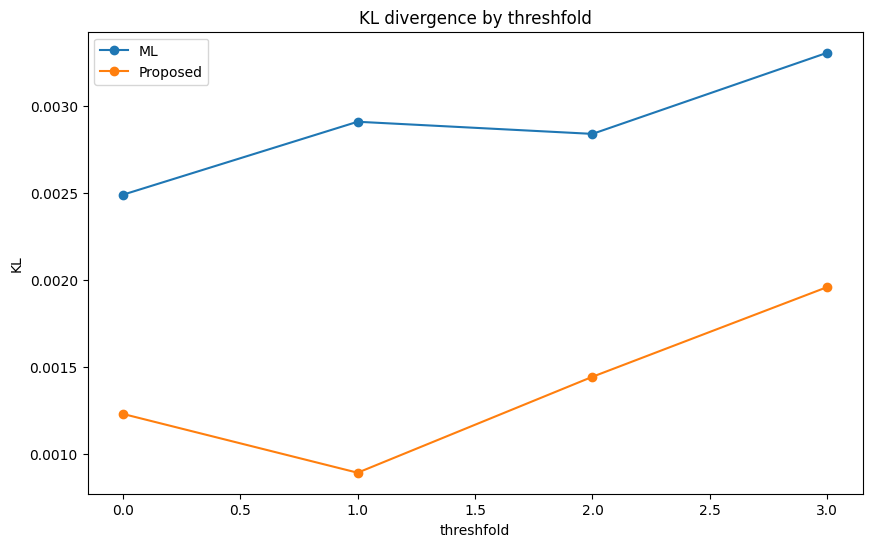

In [34]:
KL_list = np.array(KL_list).T
label = ["sample mean", "ML", "Proposed"]

plt.figure(figsize=(10, 6))
for i in range(2):
    plt.plot(KL_list[i+1], marker='o', linestyle='-', label=label[i+1]) # マーカーを'o'に設定し、線種を'-'に設定
plt.xlabel("threshfold")
plt.ylabel("KL")
plt.legend()
plt.title("KL divergence by threshfold")
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1行2列のサブプロットを作成

# Xのヒストグラムを描画
axes[0].hist(X[:, 1], bins=30, label='X', alpha=0.5)
axes[0].set_xlabel('X values')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of X')
axes[0].legend()

# X_biasのヒストグラムを描画
axes[1].hist(X_bias[:, 1], bins=30, label='X_bias', alpha=0.5, color='orange')
axes[1].set_xlabel('X_bias values')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of X_bias')
axes[1].legend()

plt.show()

# 1次元のヒストグラムでクラス別で色分けして表示
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for cls in range(2): # クラス数は2
    X_cls = X_bias[y_bias == cls]
    plt.hist(X_cls[:, 1], label=f'Class {cls}', alpha=0.7, bins=20)
plt.title('Histogram of Feature X_1 by Class (Biased Data)')
plt.xlabel('Feature X_1')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
for cls in range(2): # クラス数は2
    X_cls = X[y == cls]
    plt.hist(X_cls[:, 1], label=f'Class {cls}', alpha=0.7, bins=20)
plt.title('Histogram of Feature X_1 by Class (Non-Biased Data)')
plt.xlabel('Feature X_1')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()



# 事後分布の可視化
plt.figure(figsize=(10, 6))
for i in range(beta_posterior.shape[1]):
    plt.hist(beta_posterior[:, i], bins=30, alpha=0.7, label=f'β_{i}')
plt.title('Posterior Distribution of Beta (Biased Data)')
plt.xlabel('Beta Values')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 平均と標準偏差の表示
beta_mean = np.mean(beta_posterior, axis=0)
beta_std = np.std(beta_posterior, axis=0)
print("Betaの平均:", beta_mean)
print("Betaの標準偏差:", beta_std)

# 事後分布のトレースプロット
plt.figure(figsize=(10, 6))
for i in range(beta_posterior.shape[1]):
    plt.plot(beta_posterior[:, i], label=f'β_{i}')
plt.title('Trace Plot of Beta Posterior (Biased Data)')
plt.xlabel('Iteration')
plt.ylabel('Beta Values')
plt.legend()
plt.show()


# バイアスアルゴリズム： 非線形

In [35]:
Ex_num = 100 # パラメータを生成する回数

# 特徴量の数を設定
n_features = 1

# 特徴量の平均と標準偏差を設定
X_mu = [1]
X_sigma = [3]

# パラメータの平均と標準偏差を設定
beta_mu = [-2,4]
beta_sigma = [0.5,0.5]

threshfold_list = [-3, -1, 1, 3]

KL_list = [] # 結果格納用 (threshfoldの数, 3)→ 標本平均, 比較手法，提案手法

for threshfold in threshfold_list:

    KL_list_proposed_by_condition = []
    KL_list_sample_mean_by_condition = []
    KL_list_ML_by_condition = []

    trial = 0
    with tqdm() as pbar:
        while trial < Ex_num: # パラメータによるモンテカルロ平均（ベイズ最適な推定量）
            # クラスをインスタンス化
            generator = GenerateData_binomial(
                n_features=n_features,
                X_mu_list=X_mu,
                X_sigma_list=X_sigma,
                beta_mu=beta_mu, # beta_mu_matrixをbeta_muに変更
                beta_sigma=beta_sigma # beta_sigma_matrixをbeta_sigmaに変更
            )

            # データを生成
            X, y = generator.generate_non_bias_data()
            X_bias, y_bias = generator.generate_bias_data(n_samples=100, X_features_bias= 1 , threshfold= threshfold,sample_type="threshfold_smooth")

            if (y_bias.mean() != 1) & (y_bias.mean() != 0): # 0と1両方あるサンプルが生成できた場合のみ計算を実行する

                b_0 = np.array([0.001, 0.001])
                B_0 = np.array([np.diag([100, 100])]) # B_0の形状を変更

                burn = 2000
                draw = 5000

                # proposed_method_binomialのインスタンスを作成
                method = proposed_method_binomial(X_bias, y_bias, b_0, B_0, X_mu, X_sigma, burn, draw) # proposed_methodをproposed_method_binomialに変更
                compared_method = compared_methods(X_bias, y_bias, X_mu, X_sigma)

                # sample_betaメソッドを実行
                beta_posterior = method.sample_beta()

                P_true = y.mean()
                P_sample_mean = y_bias.mean()
                P_ML = compared_method.maximum_likelihood(draw=draw)
                P_proposed = method.estimate()

                KL_list_sample_mean_by_condition.append(KLD(P_true, P_sample_mean))
                KL_list_ML_by_condition.append(KLD(P_true, P_ML))
                KL_list_proposed_by_condition.append(KLD(P_true, P_proposed))

                pbar.update(1)
                trial += 1
            else:
                print("バイアスサンプルの生成に失敗しました")

    # 提案手法と比較手法の結果を表示
    print(f"実験条件:{threshfold=}")
    print("サンプル平均P:", np.mean(KL_list_sample_mean_by_condition))
    print("最尤推定P:", np.mean(KL_list_ML_by_condition))
    print("提案手法P:", np.mean(KL_list_proposed_by_condition))

    KL_list.append([np.mean(KL_list_sample_mean_by_condition), np.mean(KL_list_ML_by_condition), np.mean(KL_list_proposed_by_condition)])
KL_list

100it [02:04,  1.24s/it]


実験条件:threshfold=-3
サンプル平均P: 0.020945786862912364
最尤推定P: 0.002520850539685793
提案手法P: 0.0006976276522803293


100it [01:57,  1.17s/it]


実験条件:threshfold=-1
サンプル平均P: 0.05116754976357381
最尤推定P: 0.002512001655543734
提案手法P: 0.0008133224783569871


100it [01:57,  1.18s/it]


実験条件:threshfold=1
サンプル平均P: 0.11446196233596405
最尤推定P: 0.0025033306322739066
提案手法P: 0.0009201739922746721


100it [01:55,  1.15s/it]

実験条件:threshfold=3
サンプル平均P: 0.20214469653757183
最尤推定P: 0.0025651043361754277
提案手法P: 0.0009672641678958549


[[np.float64(0.020945786862912364),
  np.float64(0.002520850539685793),
  np.float64(0.0006976276522803293)],
 [np.float64(0.05116754976357381),
  np.float64(0.002512001655543734),
  np.float64(0.0008133224783569871)],
 [np.float64(0.11446196233596405),
  np.float64(0.0025033306322739066),
  np.float64(0.0009201739922746721)],
 [np.float64(0.20214469653757183),
  np.float64(0.0025651043361754277),
  np.float64(0.0009672641678958549)]]

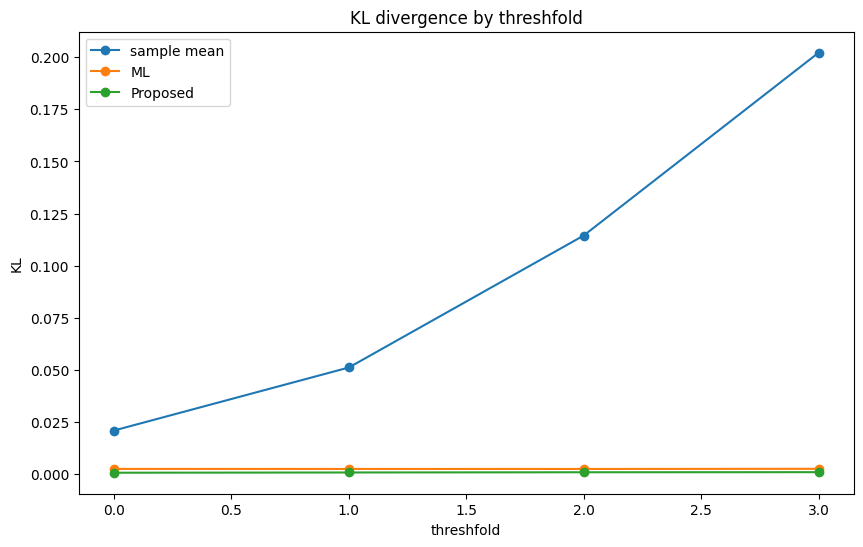

In [36]:
KL_list = np.array(KL_list).T
label = ["sample mean", "ML", "Proposed"]

plt.figure(figsize=(10, 6))
for i in range(3):
    plt.plot(KL_list[i], marker='o', linestyle='-', label=label[i]) # マーカーを'o'に設定し、線種を'-'に設定
plt.xlabel("threshfold")
plt.ylabel("KL")
plt.legend()
plt.title("KL divergence by threshfold")
plt.show()

